In [10]:
import getpass
user_id = getpass.getuser()

import sys
sys.path.append(f"/home/{user_id}/OTTEHR/")

import matplotlib.pyplot as plt
from math import floor, ceil
from mimic_common import *
import matplotlib.ticker as mtick
import numpy as np
import os
import pandas as pd
from scipy.stats import norm
import seaborn as sns
from statistics import median

In [11]:
def read_df(group_name, group_1, group_2, log=False, suffix = None):
    """ 
    Absoluate bound for filtering out ratios
    """
    target_equity_path = os.path.join(mimic_output_dir, f"exp4_{group_name}_{group_2}2{group_1}_equity.csv")
    if suffix is not None:
        target_equity_path = os.path.join(mimic_output_dir, f"exp4_{group_name}_{group_2}2{group_1}_{suffix}_equity.csv")
    target_equity_df = pd.read_csv(target_equity_path, header=0, index_col=None)
    target_labels = list(target_equity_df['target_label'])
    target_pred_labels = list(target_equity_df['trans_target_pred_label'])
    if log:
        target_labels = [np.log(x) for x in target_labels]
        target_pred_labels = [np.log(x) for x in target_pred_labels]

    return target_labels, target_pred_labels

group_1 is: Self_Pay, group_2 is: Private
group_1 is: Self_Pay, group_2 is: Government
group_1 is: Self_Pay, group_2 is: Medicare
group_1 is: Self_Pay, group_2 is: Medicaid
group_1 is: Private, group_2 is: Self_Pay
group_1 is: Private, group_2 is: Government
group_1 is: Private, group_2 is: Medicare
group_1 is: Private, group_2 is: Medicaid
group_1 is: Government, group_2 is: Self_Pay
group_1 is: Government, group_2 is: Private
group_1 is: Government, group_2 is: Medicare
group_1 is: Government, group_2 is: Medicaid
group_1 is: Medicare, group_2 is: Self_Pay
group_1 is: Medicare, group_2 is: Private
group_1 is: Medicare, group_2 is: Government
group_1 is: Medicare, group_2 is: Medicaid
group_1 is: Medicaid, group_2 is: Self_Pay
group_1 is: Medicaid, group_2 is: Private
group_1 is: Medicaid, group_2 is: Government
group_1 is: Medicaid, group_2 is: Medicare


/tmp/ipykernel_3668/4051008223.py:49: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(os.path.join(mimic_output_dir, f"{group_name}_target_duration_diff.png"), bbox_inches='tight')
/home/wanxinli/.local/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


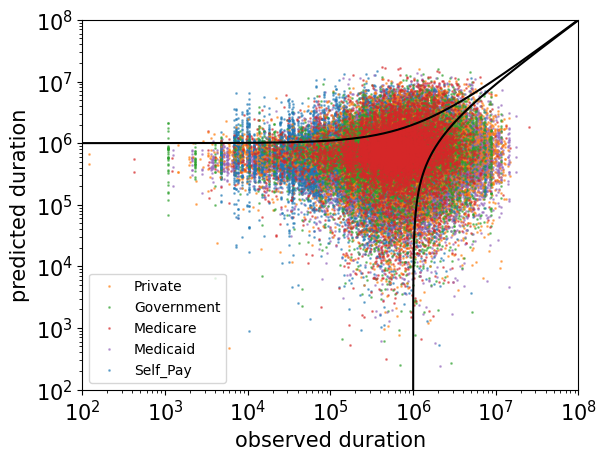

In [12]:
# group_name = 'marital_status'
# groups = ['MARRIED', 'SINGLE', 'WIDOWED', 'DIVORCED', 'SEPARATED']

group_name = 'insurance'
groups = ['Self_Pay', 'Private', 'Government', 'Medicare', 'Medicaid']
cmap = { 0:'k',1:'blue',2:'y',3:'g',4:'r' }

ax = plt.gca()
for i in range(len(groups)):
    for j in range(len(groups)): # for each pair of groups, we only consider it once
        if i == j:
            continue
        group_1 = groups[i]
        group_2 = groups[j]
        print(f"group_1 is: {group_1}, group_2 is: {group_2}")
        
        target_label, target_pred_label = read_df(group_name, group_1, group_2, log=False)
        ax.scatter(target_label, target_pred_label, s=1, alpha=0.5, color=f"C{j}", label=group_2)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('observed duration', fontsize=15)
ax.set_ylabel('predicted duration', fontsize=15)



#remove duplicates
handles, labels = plt.gca().get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
    if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)

plt.legend(newHandles, newLabels)
plt.ylim(10**2, 10**8)
plt.xlim(10**2, 10**8)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)


x = np.linspace(10**2, 10**8, 10**7)
thres = 10**6
y = x + thres
plt.plot(x, y, c='black') # plot boundary to determine outliers

y = x - thres
plt.plot(x, y, c='black') # plot boundary to determine outliers
plt.savefig(os.path.join(mimic_output_dir, f"{group_name}_target_duration_diff.png"), bbox_inches='tight')
 

10000
[0.060025, 0.055475, 0.078425, 0.05775, 0.088775]


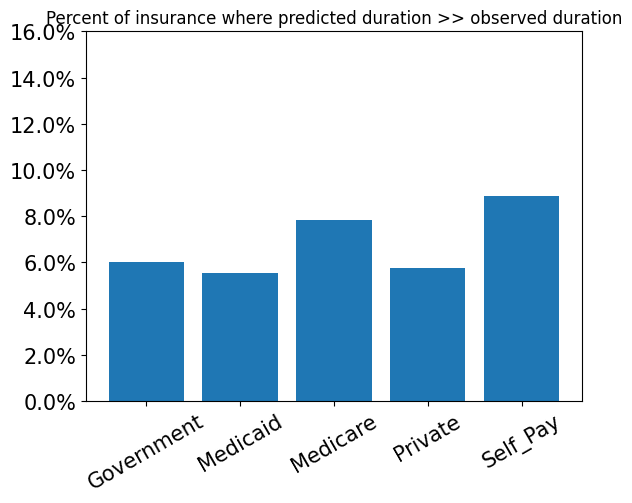

In [13]:
# Zoom in points that are outliers of the subset whose predicted duration >> observed duration 

plans = []
for i in range(len(groups)):
    for j in range(len(groups)): # for each pair of groups, we only consider it once
        if i == j:
            continue
        group_1 = groups[i]
        group_2 = groups[j]
        target_label, target_pred_label = read_df(group_name, group_1, group_2, log=False)
        for x, y in zip(target_label, target_pred_label):
            if y > x+thres  and y > 0:
                plans.append(group_2)

unique_values, counts = zip(*sorted(Counter(plans).items()))
target_label, target_pred_label = read_df(group_name, group_1, group_2, log=False)
print(len(target_label))
counts = [x/(len(target_label)*(len(groups)-1)) for x in counts]
print(counts)
ret = plt.bar(unique_values, counts)
plt.ylim(0, 0.16)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xticks(rotation=30)

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.title(f"Percent of {group_name} where predicted duration >> observed duration")
plt.savefig(os.path.join(mimic_output_dir, f'{group_name}_longer_predicted_duration.pdf'), bbox_inches='tight')



[0.119475, 0.149325, 0.10515, 0.11465, 0.05065]


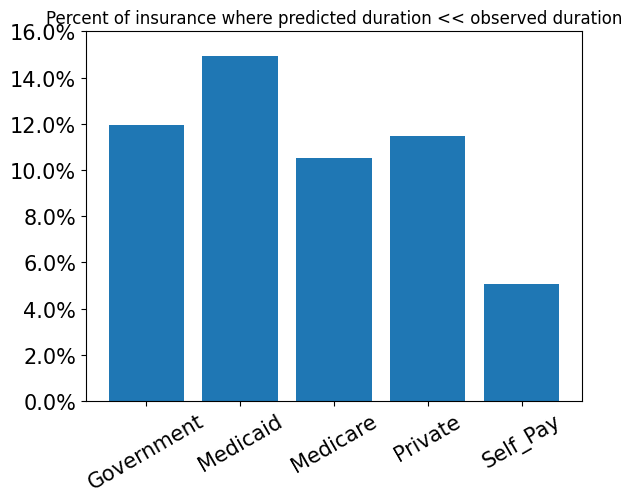

In [14]:
thres = 10**6
plans = []
for i in range(len(groups)):
    for j in range(len(groups)): # for each pair of groups, we only consider it once
        if i == j:
            continue
        group_1 = groups[i]
        group_2 = groups[j]
        target_label, target_pred_label = read_df(group_name, group_1, group_2, log=False)
        for x, y in zip(target_label, target_pred_label):
            if y < x-thres  and y > 0:
                plans.append(group_2)

unique_values, counts = zip(*sorted(Counter(plans).items()))
counts = [x/(len(target_label)*(len(groups)-1)) for x in counts]
print(counts)
plt.bar(unique_values, counts)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xticks(rotation=30)
plt.ylim(0, 0.16)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.title(f"Percent of {group_name} where predicted duration << observed duration")
plt.savefig(os.path.join(mimic_output_dir, f'{group_name}_shorter_predicted_duration.pdf'), bbox_inches='tight')

